# This notebook contains examples of how to use the functions defines in ExcessMortalityFunctions.py

In this notebook, we first generate some synthetic data to use, before illustrating the use of the functions. 

Some additional advanced examples of use can be found in older versions of the github repository, see the files named "TestingAndDevelopment" in the commit history

Sections in this notebook:

* Generate synthetic data
* Simple running mean (simple average)
* Functions for grouping by week, month and year
* Main running mean function (average of surrounding years). With Excess and Z-score calculations
* Main running mean function, Poisson-distribution assumption, monthly data
* Main running mean function, Poisson-distribution assumption, daily data
* Iterative function for omitting outliers from running mean
* Mortality crises identification function

In [1]:
# Load packages to be used here
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Load main functions
import ExcessMortalityFunctions as emf

# Load poisson functions from scipy to use for generating synthetic data (scipy.stats.poisson is also used in ExcessMortalityFunctions)
from scipy.stats import poisson

# # For reloading in case changes are made in main files
# from importlib import reload
# reload(emf)

%matplotlib widget

# Generate synthetic data

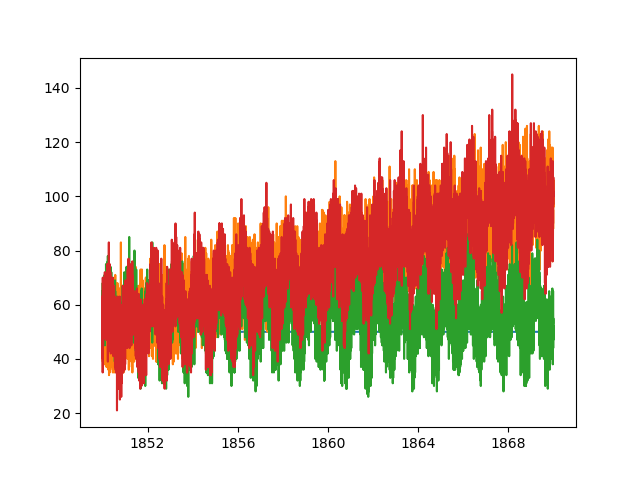

In [2]:
# Generate some data for testing
d1 = np.datetime64('1850-01-01')
d2 = np.datetime64('1870-01-01')
ts = np.arange(d1,d2)

# Constant
curMean = 50 
curBase = poisson.rvs(curMean,size = len(ts))
curBase = curMean * np.ones(len(ts))

# Linearly increasing
curMean2 = 100
allMeans = np.linspace(curMean,curMean2,len(ts))
curBase2 = poisson.rvs(allMeans,size = len(ts))

# Sinusoidal
tDays = (ts -ts[0])/np.timedelta64(1,'D')
sinAmp = 10
sinPer = 2*np.pi/365.25
# curBase3 = np.round(poisson.rvs(curMean,size = len(ts)) + sinAmp * np.sin(tDays * sinPer))
curBase3 = np.round(poisson.rvs(curMean,size = len(ts)) + sinAmp * np.sin(tDays * sinPer) + sinAmp/2)


# Sinusoidal and linear
tDays = (ts -ts[0])/np.timedelta64(1,'D')
sinAmp = 10
sinPer = 2*np.pi/365.25
curBase4 = np.round(poisson.rvs(allMeans,size = len(ts)) + sinAmp * np.sin(tDays * sinPer))

# Plot data to check
fig,ax = plt.subplots()
ax.plot(ts,curBase)
ax.plot(ts,curBase2)
ax.plot(ts,curBase3)
ax.plot(ts,curBase4)


In [3]:
# Collect synthetic data in dataframe
df = pd.DataFrame(
    index = ts,
    data={
        'Base':curBase,
        'Base2':curBase2,
        'Base3':curBase3,
        'Base4':curBase4,
        }
)


In [4]:
# Make a new version with outliers
dfOut = df.copy()

# Random dates increased
dfOut.loc[dfOut.sample(50).index] += curMean

# Increased period
dfOut.iloc[4000:4050] += curMean


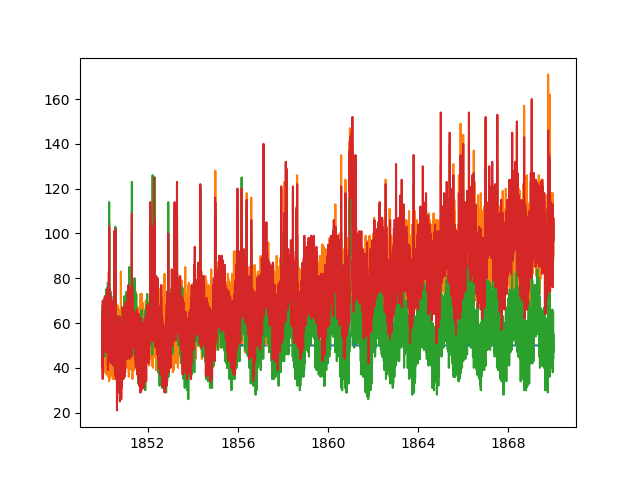

In [5]:
# Plot data to check
fig,ax = plt.subplots()
ax.plot(dfOut.index,dfOut.Base)
ax.plot(dfOut.index,dfOut.Base2)
ax.plot(dfOut.index,dfOut.Base3)
ax.plot(dfOut.index,dfOut.Base4)

# Simple running mean

A simple convolution to get 7-day running mean

(-40029.0, -39749.0)

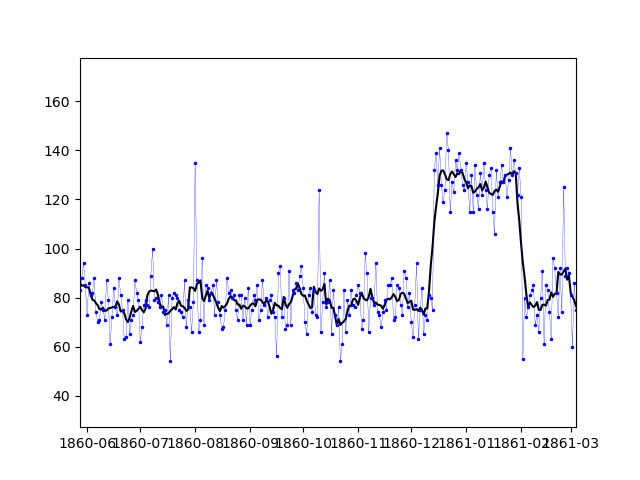

In [6]:
curData = dfOut.Base2 
curRnData = emf.rnMeanSimple(curData)
curRnTime = emf.rnTimeSimple(curData.index)


fig,ax = plt.subplots()
ax.plot(curRnTime,curRnData,'k')
ax.plot(curData,'b.-',lw=0.2,ms=3)

ax.set_xlim([ts[3800],ts[4080]])

# Grouping-functions

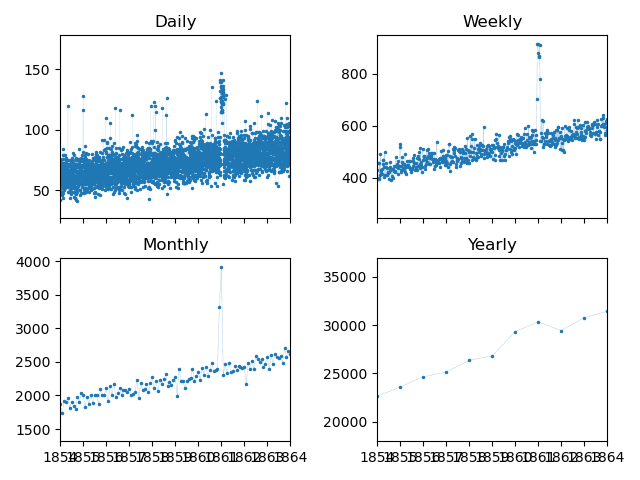

In [7]:
curData = dfOut.Base2

curDataWeek = emf.groupByWeek(curData)
curDataMonth = emf.groupByMonth(curData)
curDataYear = emf.groupByYear(curData)


fig,axs = plt.subplots(2,2,sharex=True)

axs[0,0].plot(curData,'.:',lw=0.1,ms=3)
axs[0,1].plot(curDataWeek,'.:',lw=0.3,ms=3)
axs[1,0].plot(curDataMonth,'.:',lw=0.3,ms=3)
axs[1,1].plot(curDataYear,'.:',lw=0.3,ms=3)

axs[0,0].set_title('Daily')
axs[0,1].set_title('Weekly')
axs[1,0].set_title('Monthly')
axs[1,1].set_title('Yearly')

axs[0,0].set_xlim(left=np.datetime64('1854'),right=np.datetime64('1864'))
fig.tight_layout()

# Main function for calculating running mean

In [8]:
curData = dfOut.Base2 
numYears = 5 
timeResolution = 'Month'

# Group data by month
curDataMonth = emf.groupByMonth(curData)

# Calculate mean and standard deviation
curBaseline,curStd = emf.rnMean(curDataMonth,numYears=numYears,timeResolution=timeResolution)


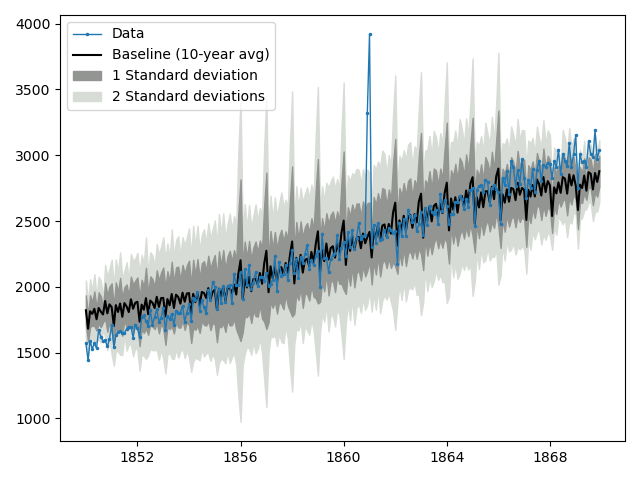

In [9]:
fig,ax = plt.subplots()

ax.plot(curDataMonth,'.-',lw=1,ms=3,zorder=5,label='Data')
ax.plot(curBaseline,'k',zorder=4,label=f'Baseline ({2*numYears}-year avg)')
ax.fill_between(curBaseline.index,
                curBaseline - curStd,
                curBaseline + curStd,
                color='xkcd:gray',
                zorder=3,
                label='1 Standard deviation'
                )
ax.fill_between(curBaseline.index,
                curBaseline - 2 * curStd,
                curBaseline + 2 * curStd,
                color='xkcd:light gray',
                zorder=2,
                label='2 Standard deviations'
                )

ax.legend(loc='upper left')
fig.tight_layout()

### Calculate excess and Z-score

In [10]:
curExc,curZsc,curExcPct = emf.getExcessAndZscore(curDataMonth,curBaseline,curStd)

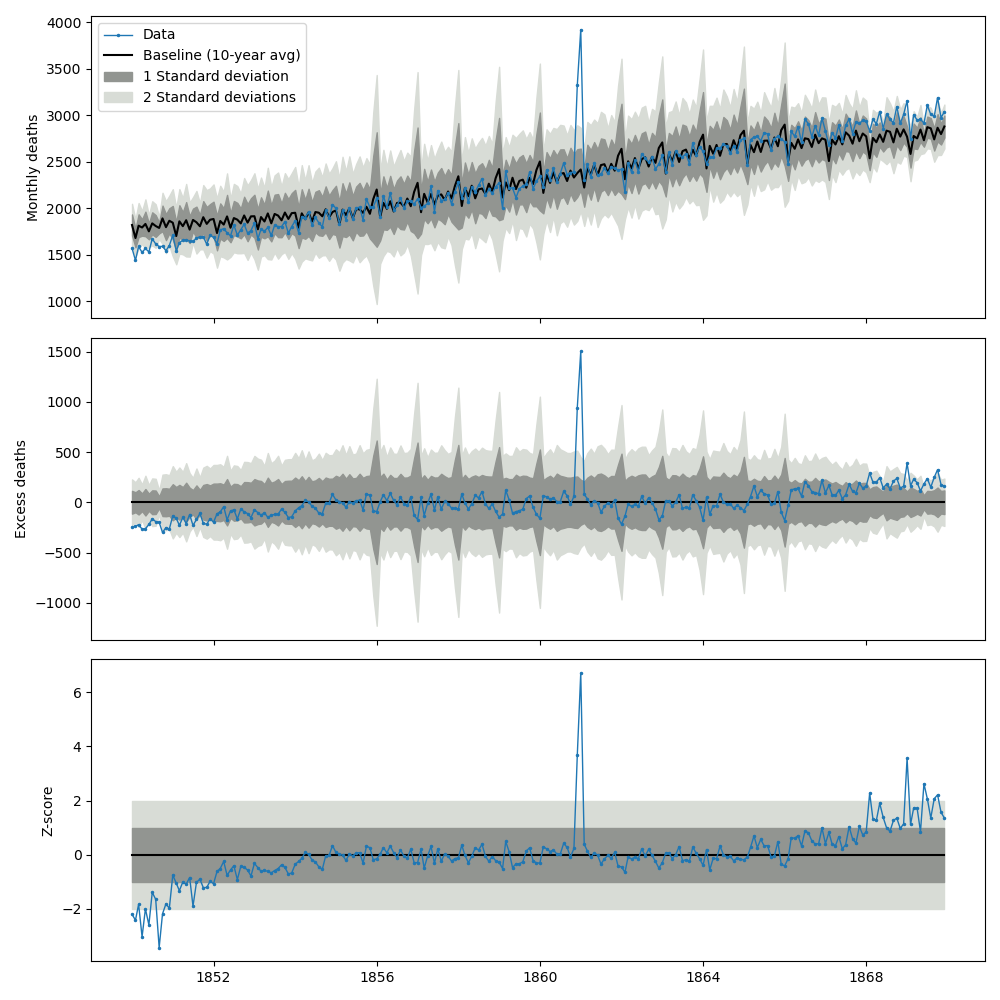

In [11]:
fig,(ax,ax2,ax3) = plt.subplots(3,1,figsize=(10,10),sharex=True)

ax.plot(curDataMonth,'.-',lw=1,ms=3,zorder=5,label='Data')
ax.plot(curBaseline,'k',zorder=4,label=f'Baseline ({2*numYears}-year avg)')
ax.fill_between(curBaseline.index,
                curBaseline - curStd,
                curBaseline + curStd,
                color='xkcd:gray',
                zorder=3,
                label='1 Standard deviation'
                )
ax.fill_between(curBaseline.index,
                curBaseline - 2 * curStd,
                curBaseline + 2 * curStd,
                color='xkcd:light gray',
                zorder=2,
                label='2 Standard deviations'
                )


ax2.plot(curDataMonth - curBaseline,'.-',lw=1,ms=3,zorder=5,label='Excess')
ax2.plot(curBaseline.index,np.zeros(curBaseline.shape),'k',zorder=4,label=f'Baseline ({2*numYears}-year avg)')
ax2.fill_between(curBaseline.index,
                - curStd,
                + curStd,
                color='xkcd:gray',
                zorder=3,
                label='1 Standard deviation'
                )
ax2.fill_between(curBaseline.index,
                - 2 * curStd,
                + 2 * curStd,
                color='xkcd:light gray',
                zorder=2,
                label='2 Standard deviations'
                )



ax3.plot(curZsc,'.-',lw=1,ms=3,zorder=5,label='Z-score')
ax3.plot(curBaseline.index,np.zeros(curBaseline.shape),'k',zorder=4,label=f'Baseline ({2*numYears}-year avg)')
ax3.fill_between(curBaseline.index,
                - np.ones(curStd.shape),
                + np.ones(curStd.shape),
                color='xkcd:gray',
                zorder=3,
                label='1 Standard deviation'
                )
ax3.fill_between(curBaseline.index,
                - 2 * np.ones(curStd.shape),
                + 2 * np.ones(curStd.shape),
                color='xkcd:light gray',
                zorder=2,
                label='2 Standard deviations'
                )


ax.set_ylabel('Monthly deaths')
ax2.set_ylabel('Excess deaths')
ax3.set_ylabel('Z-score')

ax.legend(loc='upper left')
fig.tight_layout()

## Functions for poisson-distribution assumption

In [12]:
# Calculate mean and poisson survival-funtion
curBaseline,curSF = emf.rnMean(curDataMonth,numYears=numYears,timeResolution=timeResolution,distributionType='Poisson')

# Get the probability intervals
intervalValue = 0.75
curBot,curTop = emf.getPoissonIntervals(intervalValue,curBaseline)
intervalValue2 = 0.95
curBot2,curTop2 = emf.getPoissonIntervals(intervalValue2,curBaseline)

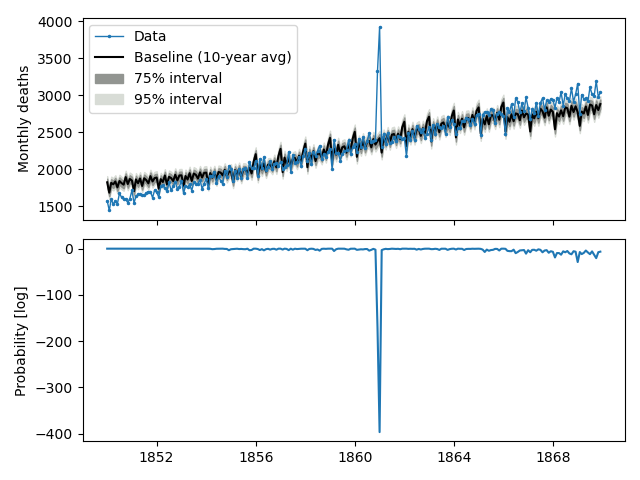

In [13]:
fig,(ax,ax2) = plt.subplots(2,1,sharex=True)

ax.plot(curDataMonth,'.-',lw=1,ms=3,zorder=5,label='Data')
ax.plot(curBaseline,'k',zorder=4,label=f'Baseline ({2*numYears}-year avg)')

ax.fill_between(curBaseline.index,
                curBot,
                curTop,
                color='xkcd:gray',
                zorder=3,
                label=f'{100*intervalValue:2.0f}% interval'
                )
ax.fill_between(curBaseline.index,
                curBot2,
                curTop2,
                color='xkcd:light gray',
                zorder=2,
                label=f'{100*intervalValue2:2.0f}% interval'
                )

ax2.plot(curSF)

ax.legend(loc='upper left')

ax.set_ylabel('Monthly deaths')
ax2.set_ylabel('Probability [log]')
fig.tight_layout()

# Example using Poisson-distribution functions on daily data

In [14]:
# Calculate mean and poisson survival-funtion
curData = dfOut.Base2 
curBaseline,curSF = emf.rnMean(curData,numYears=numYears,timeResolution='Day',distributionType='Poisson')

# Get the probability intervals
intervalValue = 0.75
curBot,curTop = emf.getPoissonIntervals(intervalValue,curBaseline)
intervalValue2 = 0.95
curBot2,curTop2 = emf.getPoissonIntervals(intervalValue2,curBaseline)

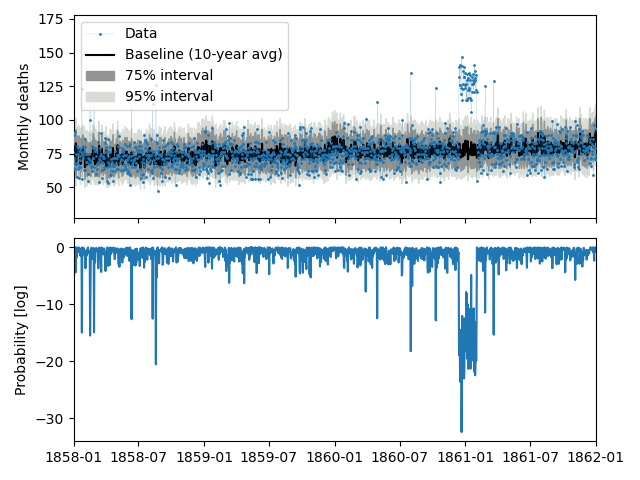

In [15]:
fig,(ax,ax2) = plt.subplots(2,1,sharex=True)

ax.plot(curData,'.-',lw=0.1,ms=2,zorder=5,label='Data')
ax.plot(curBaseline,'k',zorder=4,label=f'Baseline ({2*numYears}-year avg)')

ax.fill_between(curBaseline.index,
                curBot,
                curTop,
                color='xkcd:gray',
                zorder=3,
                label=f'{100*intervalValue:2.0f}% interval'
                )
ax.fill_between(curBaseline.index,
                curBot2,
                curTop2,
                color='xkcd:light gray',
                zorder=2,
                label=f'{100*intervalValue2:2.0f}% interval'
                )

ax2.plot(curSF)

ax.legend(loc='upper left')

ax.set_ylabel('Monthly deaths')
ax2.set_ylabel('Probability [log]')

ax.set_xlim(left=np.datetime64('1858'),right=np.datetime64('1862'))
fig.tight_layout()

# Iterative functions for omitting outliers from running mean calculation

## First, a single iteration, monthly data

In [16]:
curData = dfOut.Base2 
numYears = 5 
timeResolution = 'Month'

# Group data by month
curDataMonth = emf.groupByMonth(curData)

# Calculate mean and standard deviation
curBaseline,curStd = emf.rnMean(curDataMonth,numYears=numYears,timeResolution=timeResolution)
curExc,curZsc,curExcPct = emf.getExcessAndZscore(curDataMonth,curBaseline,curStd)

In [17]:
# Single iteration
curDataRemove = curDataMonth.copy()
curDataRemove,curBaselineOneIteration,curStandardDeviationOneIteration = emf.removeAboveThresholdAndRecalculate(curDataRemove,curZsc,ZscoreThreshold=3,numYears=numYears,timeResolution=timeResolution)


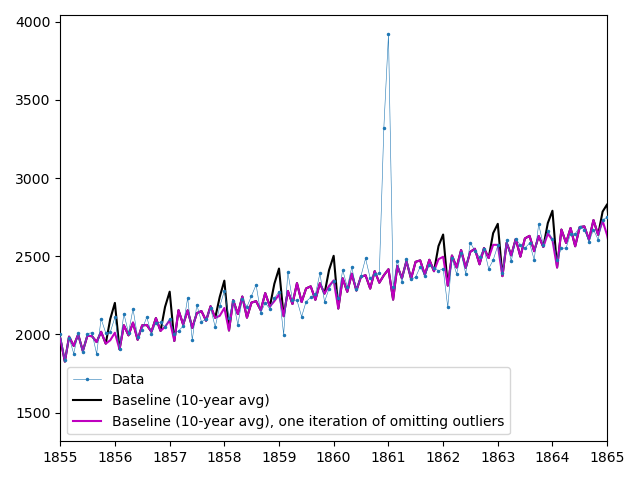

In [18]:

fig,ax = plt.subplots()

ax.plot(curDataMonth,'.-',lw=0.4,ms=3,zorder=5,label='Data')
ax.plot(curBaseline,'k',zorder=4,label=f'Baseline ({2*numYears}-year avg)')
ax.plot(curBaselineOneIteration,'m',zorder=4,label=f'Baseline ({2*numYears}-year avg), one iteration of omitting outliers')

ax.legend()
ax.set_xlim(left=np.datetime64('1855'),right=np.datetime64('1865'))
fig.tight_layout()

## Omit all, daily data

In [19]:
curData = dfOut.Base2 
numYears = 5 
timeResolution = 'Day'


# Calculate mean and standard deviation
curBaseline,curStd = emf.rnMean(curData,numYears=numYears,timeResolution=timeResolution)
curExc,curZsc,curExcPct = emf.getExcessAndZscore(curData,curBaseline,curStd)

In [20]:
# Remove all above
_,curBaselineFull,curStandardDeviationFull = emf.removeAboveThresholdAndRecalculateRepeatFull(curData,ZscoreThreshold=3,numYears=numYears,timeResolution=timeResolution)


(-41272.0, -39446.0)

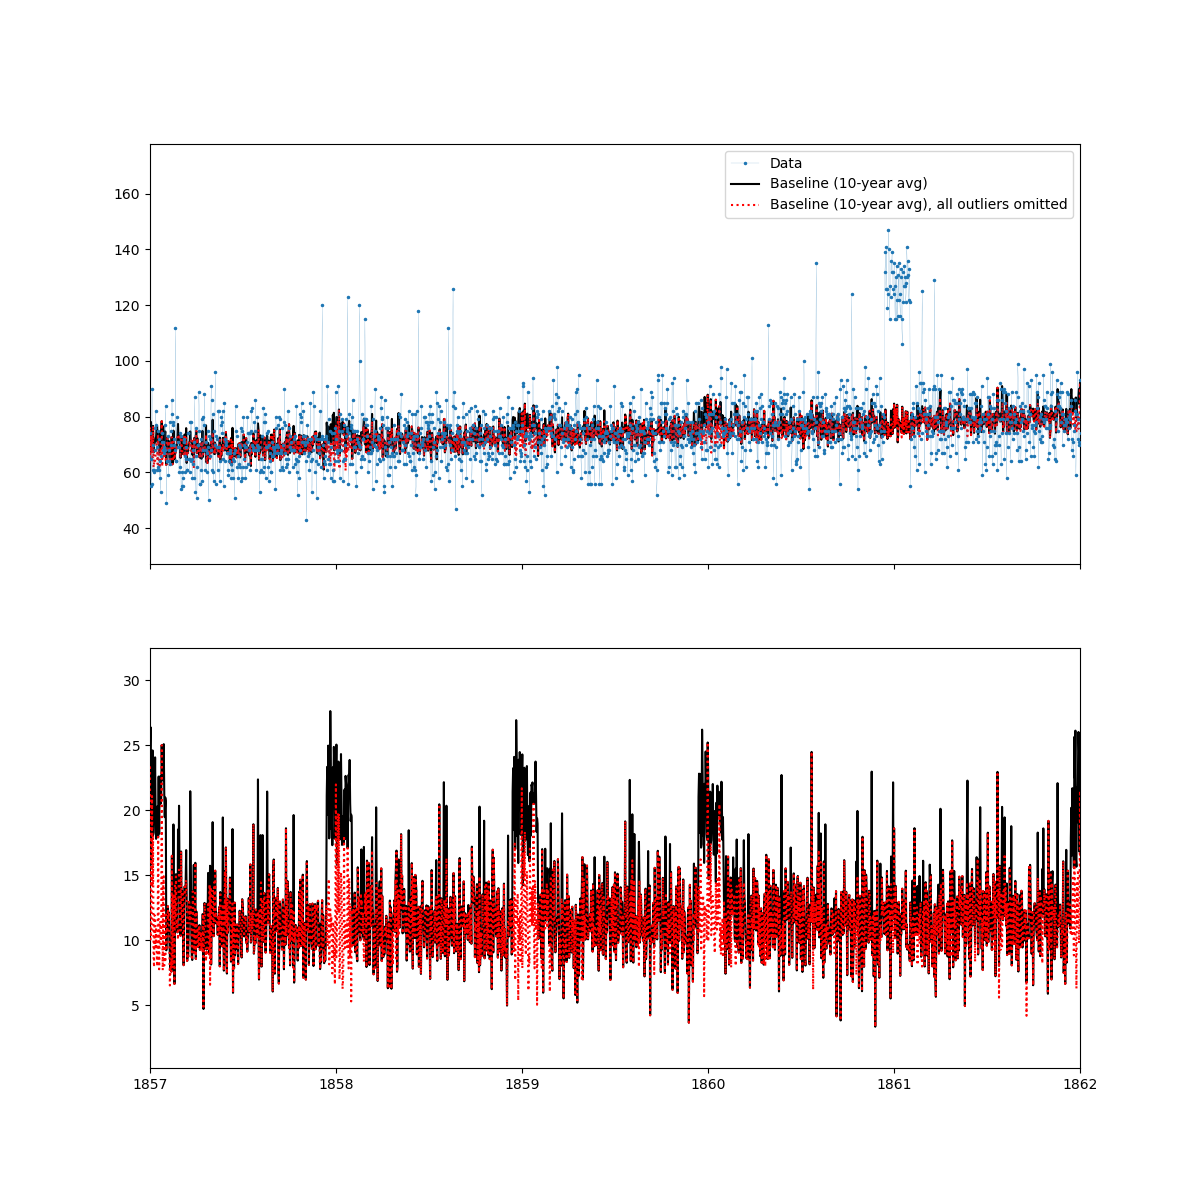

In [21]:

fig,(ax,ax2) = plt.subplots(2,1,figsize=(12,12),sharex=True)

ax.plot(curData,'.-',lw=0.1,ms=3,zorder=5,label='Data')
ax.plot(curBaseline,'k',zorder=4,label=f'Baseline ({2*numYears}-year avg)')
ax.plot(curBaselineFull,'r:',zorder=4,label=f'Baseline ({2*numYears}-year avg), all outliers omitted')


ax2.plot(curStd,'k',zorder=4,label=f'Standard deviation, ({2*numYears}-year avg)')
ax2.plot(curStandardDeviationFull,'r:',zorder=4,label=f'Standard deviation, ({2*numYears}-year avg), all outliers omitted')

ax.legend()
ax.set_xlim(left=np.datetime64('1857'),right=np.datetime64('1862'))

# Mortality crises identification function

In this example, the baseline without outliers (as determined above) is used

In [22]:

curExcFull,curZscFull,curExcPctFull = emf.getExcessAndZscore(curData,curBaselineFull,curStandardDeviationFull)

curTime = curBaseline.index 
curExcess = curData - curBaselineFull
curZscore = curZscFull

dateGroups,allExcess = emf.determineMortalityCrisis(curTime,curExcess,curZscore,upperThreshold=3,lowerThreshold=2,maxDaysBelowThreshold=7,minDurationOfCrisis=0,returnExcessCount=True)

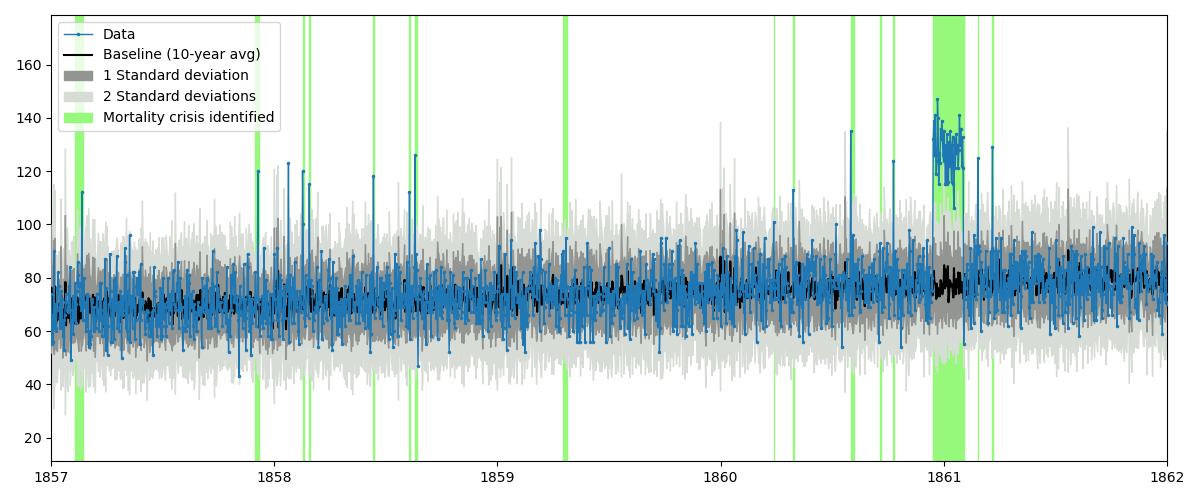

In [23]:
fig,ax = plt.subplots(figsize=(12,5))

ax.plot(curData,'.-',lw=1,ms=3,zorder=5,label='Data')
ax.plot(curBaselineFull,'k',zorder=4,label=f'Baseline ({2*numYears}-year avg)')
ax.fill_between(curBaselineFull.index,
                curBaselineFull - curStandardDeviationFull,
                curBaselineFull + curStandardDeviationFull,
                color='xkcd:gray',
                zorder=3,
                label='1 Standard deviation'
                )
ax.fill_between(curBaselineFull.index,
                curBaselineFull - 2 * curStandardDeviationFull,
                curBaselineFull + 2 * curStandardDeviationFull,
                color='xkcd:light gray',
                zorder=2,
                label='2 Standard deviations'
                )

for i in range(len(dateGroups)):
    curTotalExcess = allExcess[i]
    if (curTotalExcess > 10):
        curDateGroup = dateGroups[i]
        ax.axvspan(curDateGroup[0],curDateGroup[1],color='xkcd:light green',label=(i==0)*'Mortality crisis identified')


ax.legend(loc='upper left')
ax.set_xlim(left=np.datetime64('1857'),right=np.datetime64('1862'))
fig.tight_layout()